# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#demographic description
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
#features description
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG1,person,ordinal,[-1]
freq,1,43,49,26


In [5]:
#demographic structure
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
#features structure
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
#features first few lines
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
#demographic first few lines
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
#features number of rows and columns
feat_info.shape

(85, 4)

In [10]:
#demographics number of rows and columns
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#splits data for ease of use
def split_function(missing_or_unknown):
    rev = list()
    for items in missing_or_unknown:
        rev.append(items[1:-1].split(','))
    return rev

missing = split_function(feat_info["missing_or_unknown"])

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
for item, missing_vals in zip(feat_info["attribute"], missing):
    if missing_vals[0] != "":
        for val in missing_vals:
            if val.isnumeric() or val.lstrip('-').isnumeric():
                val = int(val)
                
            azdias.loc[azdias[item] == val, item] = np.nan

In [13]:
# prints newly-converted NANs
azdias.head(15)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nulls = azdias.isnull().sum()
print(nulls.sort_values())

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

Text(0,0.5,'Nulls')

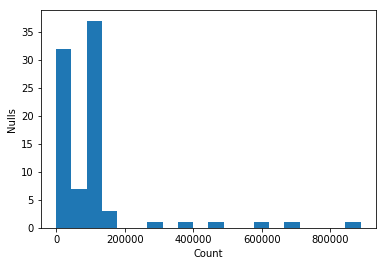

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(nulls, bins=20)
plt.xlabel("Count")
plt.ylabel("Nulls")

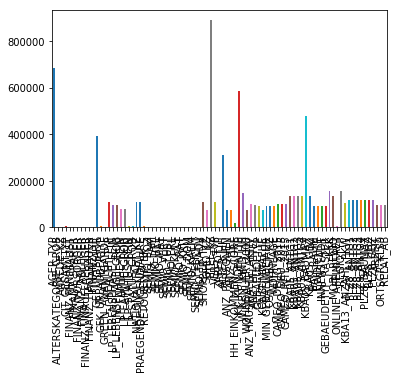

In [16]:
nulls.plot.bar()

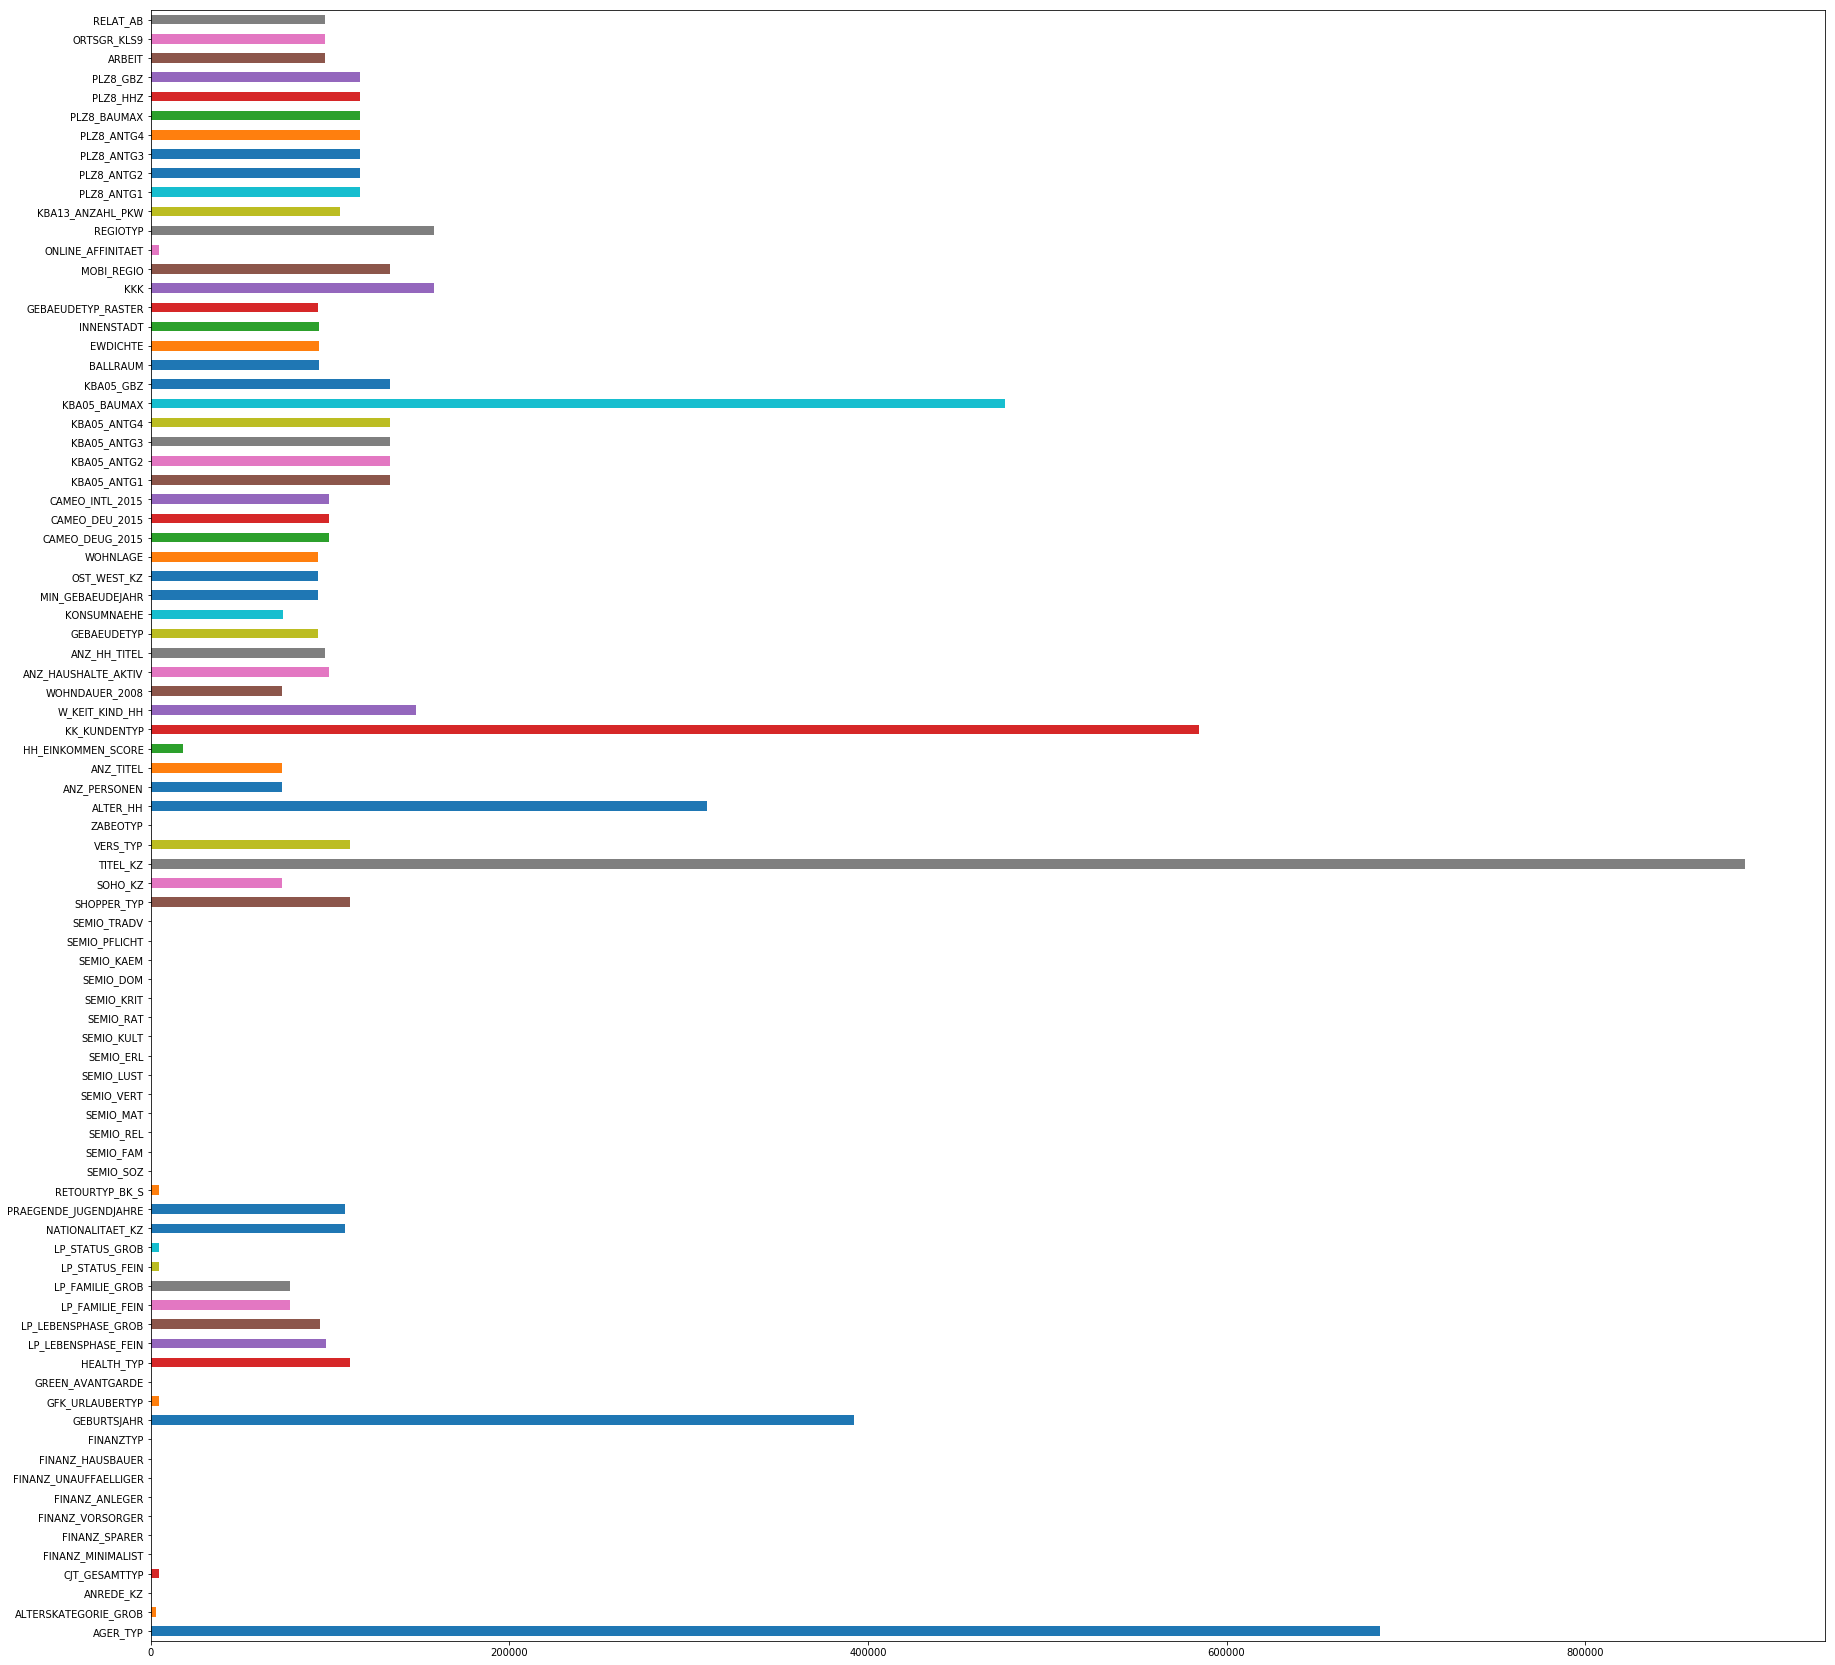

In [17]:
#cleaning up bar graph from above
nulls.plot.barh(figsize=(30,30))

In [18]:
nulls.sort_values()

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

## Outliers: anything above 30k

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = nulls[nulls>=300000]
outliers.sort_values()

ALTER_HH        310267
GEBURTSJAHR     392318
KBA05_BAUMAX    476524
KK_KUNDENTYP    584612
AGER_TYP        685843
TITEL_KZ        889061
dtype: int64

Text(0,0.5,'Nulls')

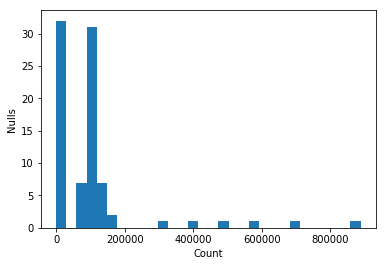

In [20]:
#histogram of nulls
plt.hist(nulls, bins=30)
plt.xlabel("Count")
plt.ylabel("Nulls")

In [21]:
azdias_no_outliers = azdias.drop(outliers)

#### Discussion 1.1.2: Assess Missing Data in Each Column
I removed columns that had above 30,000 missing datapoints. Most of the columns fall within the range of having 0-15,000 missing data points, so columns containing twice that have a large percentage of total missing data and should not be considered in further analysis within this project. 

The columns that were removed are as follows:

ALTER_HH<br>     
GEBURTSJAHR<br>             
KBA05_BAUMAX<br>                
KK_KUNDENTYP<br>                
AGER_TYP<br>                    
TITEL_KZ<br>                    

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
#find missing row values
null_rose = azdias_no_outliers.isnull().sum(axis=1)
null_rose.describe()

count    891215.00000
mean          9.39604
std          13.97187
min           0.00000
25%           3.00000
50%           4.00000
75%           6.00000
max          54.00000
dtype: float64

(array([  6.70710000e+05,   7.62590000e+04,   3.62270000e+04,
          1.28770000e+04,   1.50800000e+03,   3.05000000e+02,
          1.14300000e+04,   7.52700000e+03,   7.04000000e+02,
          7.35250000e+04]),
 array([  1. ,   6.3,  11.6,  16.9,  22.2,  27.5,  32.8,  38.1,  43.4,
         48.7,  54. ]),
 <a list of 10 Patch objects>)

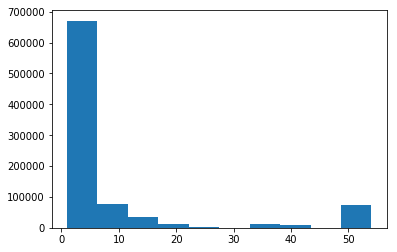

In [23]:
#plot histogram
plt.hist(null_rose[null_rose>0],bins=10)

## There are several rows with less than 30 missing values and several rows with more than 30. Though there are a few places I could split the data, 30 feels like the most reasonable seperation point.

In [24]:
# creating list of sample columns that don't have missing data
sample_columns = ['FINANZ_ANLEGER',
'FINANZ_UNAUFFAELLIGER',
'FINANZ_HAUSBAUER',
'GREEN_AVANTGARDE',             
'FINANZTYP']

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

over_20 = azdias_no_outliers[azdias_no_outliers.isnull().sum(axis=1) >= 20]
under_20 = azdias_no_outliers[azdias_no_outliers.isnull().sum(axis=1) < 20]

In [26]:
# creating comparison function to print vizualizations
def comparison(column):
    fig = plt.figure()
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text("Over 20")
    sns.countplot(over_20[column])
                            
    ax2 = fig.add_subplot(122)
    ax2.title.set_text("Under 20")
    sns.countplot(under_20[column])

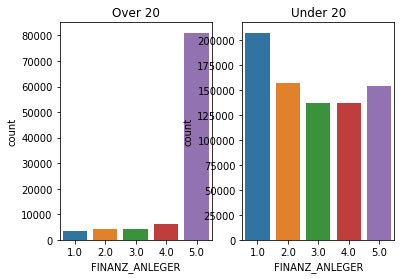

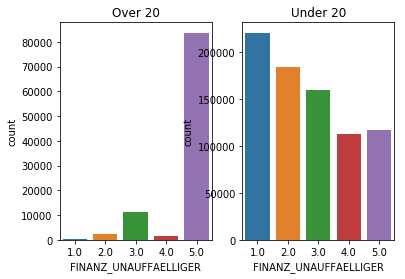

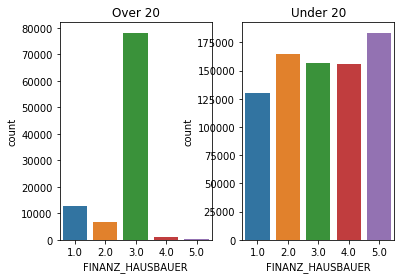

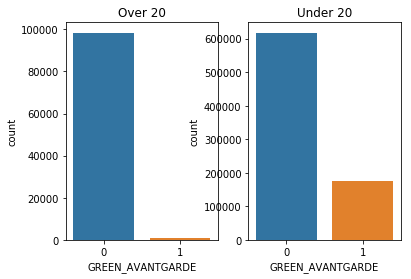

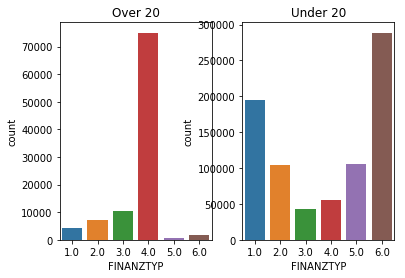

In [27]:
#calling comparison function
for n in sample_columns:
    comparison(n)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I used countplot and subplot to assess the missing data in rows (nulls). After creating the initial histogram, I noticed that there was a clear split along the 20 mark. Though I considered splitting the data at the 10 mark due to the majority of rows falling within that category, I chose 20 because it is closer to the center of the data spread.

After sorting the data into seperate data frames based on their value (below 20 or above 20), I plotted the same five columns from each data frame that contained zero missing values. I plotted each of these columns alongside one another to compare values.

The vast majority of the rows have 0-10 missing data points. This is evident when glancing at the original histogram and is confirmed with the additional graphs. I'm glad that only a small number of rows have much missing data, as this will make cleaning and analyzing more straight forward.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categories = feat_info[feat_info.type == 'categorical'].attribute

In [30]:
print(categories)

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [31]:
#sorting into binary vs multi-type categories
binary = []
multi = []
for item in categories:
    if under_20[item].nunique()<= 2:
        binary.append(item)
    else:
        multi.append(item)

In [32]:
#print binaries
for item in binary:
    print(under_20[item].value_counts())

2.0    412886
1.0    379004
Name: ANREDE_KZ, dtype: int64
0    617626
1    174264
Name: GREEN_AVANTGARDE, dtype: int64
0.0    785222
1.0      6668
Name: SOHO_KZ, dtype: int64
2.0    393045
1.0    363306
Name: VERS_TYP, dtype: int64
W    624382
O    167508
Name: OST_WEST_KZ, dtype: int64


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
under_20['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 2.0], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [34]:
under_20['OST_WEST_KZ'].unique()

array([ 1.,  2.])

In [35]:
#printing binaries again
for item in binary:
    print(under_20[item].value_counts())

2.0    412886
1.0    379004
Name: ANREDE_KZ, dtype: int64
0    617626
1    174264
Name: GREEN_AVANTGARDE, dtype: int64
0.0    785222
1.0      6668
Name: SOHO_KZ, dtype: int64
2.0    393045
1.0    363306
Name: VERS_TYP, dtype: int64
1.0    624382
2.0    167508
Name: OST_WEST_KZ, dtype: int64


#### It's bothering me that all the values are not uniform, so I am going to change them.

In [36]:
under_20['GREEN_AVANTGARDE'].replace([0, 1], [1.0, 2.0])
under_20['SOHO_KZ'].replace([0.0, 1.0], [1.0, 2.0])

1         2.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
12        1.0
13        1.0
15        1.0
16        1.0
18        1.0
19        1.0
20        1.0
21        1.0
22        1.0
23        1.0
25        1.0
27        1.0
28        1.0
29        1.0
31        1.0
32        1.0
33        1.0
34        1.0
36        1.0
37        1.0
         ... 
891190    1.0
891191    1.0
891192    1.0
891193    1.0
891194    1.0
891195    1.0
891196    1.0
891197    1.0
891198    1.0
891199    1.0
891200    1.0
891201    1.0
891202    1.0
891204    1.0
891205    1.0
891206    1.0
891207    1.0
891208    1.0
891209    1.0
891210    1.0
891211    1.0
891212    1.0
891213    1.0
891214    1.0
891215    1.0
891216    1.0
891217    1.0
891218    1.0
891219    1.0
891220    1.0
Name: SOHO_KZ, Length: 791890, dtype: float64

In [37]:
#printing binaries a third time after cleaning
for item in binary:
    print(under_20[item].value_counts())

2.0    412886
1.0    379004
Name: ANREDE_KZ, dtype: int64
0    617626
1    174264
Name: GREEN_AVANTGARDE, dtype: int64
0.0    785222
1.0      6668
Name: SOHO_KZ, dtype: int64
2.0    393045
1.0    363306
Name: VERS_TYP, dtype: int64
1.0    624382
2.0    167508
Name: OST_WEST_KZ, dtype: int64


#### Yay! All binary values now match formatting. How satisfying!


In [38]:
# print multi-values
for item in multi:
    print(under_20[item].value_counts())

2.0    94225
1.0    79747
3.0    26104
Name: AGER_TYP, dtype: int64
4.0    196804
3.0    146014
2.0    140637
5.0    110444
6.0    101080
1.0     92530
Name: CJT_GESAMTTYP, dtype: int64
6.0    288559
1.0    195142
5.0    105746
2.0    103854
4.0     55613
3.0     42976
Name: FINANZTYP, dtype: int64
12.0    128514
10.0    102311
8.0      82652
11.0     74621
5.0      70274
4.0      60336
9.0      56676
3.0      53039
1.0      50525
2.0      42480
7.0      40433
6.0      25648
Name: GFK_URLAUBERTYP, dtype: int64
1.0     399431
10.0    128294
2.0      97913
11.0     48610
8.0      21714
7.0      19447
4.0      11518
5.0      11123
9.0      10416
6.0       8408
3.0       4605
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    399431
5.0    187320
2.0     97913
4.0     49569
3.0     27246
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206146
9.0     135002
10.0    111076
2.0     110494
4.0      73748
3.0      68743
6.0      28674
5.0      27071
8.0      17404
7.0       9151
Name: LP_STATUS_FEIN, dtype

In [39]:
#drop multi-value columns
for column in multi:
    under_20 = under_20.drop(column, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I sorted attributes into lists for binary and multi-values. I then made the binary data's formatting uniform and tansformed the string data to integer data in one column. Then I dropped the multi-value columns for ease going forward.

I chose to drop the multi-value columns instead of reencoding it because I was struggling to get my code to function as intended. I kept getting unexpected results. Since the instructions said I could drop the columns for ease, I chose to go in that direction instead. See the note in the next section for more info.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "c" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### PRAEGENDE_JUGENDJAHRE info from Data_Dictionary.md
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
under_20['DECADE_PJ'] = under_20['PRAEGENDE_JUGENDJAHRE']
under_20['MOVEMENT_PJ'] = under_20['PRAEGENDE_JUGENDJAHRE']

In [41]:
"""
Sorting by decade: 
40's: 1
50's: 2
60's: 3
70's: 4
80's: 5
90's: 6
"""
decade_pj_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

"""
Sorting movements into a binary:
Adventgarde: 1
Mainstream: 2
"""
movement_pj_dict = {1:2, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:2, 11:1, 12:2, 13:1, 14:2, 15:1}

In [42]:
#replace features with new dict
under_20['DECADE_PJ'].replace(decade_pj_dict)
under_20['MOVEMENT_PJ'].replace(movement_pj_dict)

1         2.0
2         1.0
3         2.0
4         2.0
5         2.0
6         2.0
7         2.0
8         1.0
9         1.0
10        2.0
12        2.0
13        1.0
15        2.0
16        2.0
18        2.0
19        1.0
20        1.0
21        2.0
22        2.0
23        1.0
25        2.0
27        1.0
28        2.0
29        1.0
31        2.0
32        1.0
33        2.0
34        1.0
36        2.0
37        2.0
         ... 
891190    1.0
891191    2.0
891192    2.0
891193    2.0
891194    1.0
891195    2.0
891196    2.0
891197    1.0
891198    1.0
891199    2.0
891200    2.0
891201    2.0
891202    2.0
891204    2.0
891205    2.0
891206    2.0
891207    1.0
891208    2.0
891209    2.0
891210    2.0
891211    2.0
891212    2.0
891213    1.0
891214    2.0
891215    2.0
891216    2.0
891217    2.0
891218    2.0
891219    2.0
891220    2.0
Name: MOVEMENT_PJ, Length: 791890, dtype: float64

#### CAMEO_INTL_2015 from Data_DIctionary.md
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
under_20['WEALTH_CAMEO'] = under_20['CAMEO_INTL_2015']
under_20['LIFE_STAGE_CAMEO'] = under_20['CAMEO_INTL_2015']

In [44]:
#sorting by wealth (10's place)
wealth_cameo_dict = {11:1, 12:1, 13:1, 14:1, 15:1,
                     21:2, 22:2, 23:2, 24:2, 25:2,
                     31:3, 32:3, 33:3, 34:3, 35:3,
                     41:4, 42:4, 43:4, 44:4, 45:4,
                     51:5, 52:5, 53:5, 54:5, 55:5}

#sorting by life stage (1's place)
life_stage_cameo_dict = {11:1, 12:2, 13:3, 14:4, 15:5,
                         21:1, 22:2, 23:3, 24:4, 25:5,
                         31:1, 32:2, 33:3, 34:4, 35:5,
                         41:1, 42:2, 43:3, 44:4, 45:5,
                         51:1, 52:2, 53:3, 54:4, 55:5}

In [45]:
#replace features with new dict
under_20['WEALTH_CAMEO'].replace(wealth_cameo_dict)
under_20['LIFE_STAGE_CAMEO'].replace(life_stage_cameo_dict)

1         51
2         24
3         12
4         43
5         54
6         22
7         14
8         13
9         15
10        51
12        43
13        33
15        41
16        41
18        24
19        34
20        24
21        55
22        51
23        43
25        33
27        51
28        13
29        12
31        51
32        14
33        41
34        25
36        41
37        24
          ..
891190    15
891191    44
891192    32
891193    43
891194    24
891195    55
891196    23
891197    24
891198    14
891199    51
891200    52
891201    41
891202    41
891204    24
891205    34
891206    25
891207    41
891208    14
891209    51
891210    41
891211    51
891212    51
891213    34
891214    23
891215    31
891216    41
891217    51
891218    24
891219    51
891220    43
Name: LIFE_STAGE_CAMEO, Length: 791890, dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features

For this step, I engineered PRAEGENDE_JUGENDJAHRE by seperating its values into two vairables: decade and movement. I did this by creating two new dictionaries and then replacing the old features with them.

Similarly, I seperated CAMEO_INTL_2015 by seperating its values into two dictionaries by wealth level and life stage. This process was fun! I enjoyed figuring out how to sort the data by wealth and then by life stage accroding to ordinal values. Again, I replaced the old features with the new in order to have engineered, clean data to work with going forward. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
pd.set_option('display.max_columns', None)
under_20.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE_PJ,MOVEMENT_PJ,WEALTH_CAMEO,LIFE_STAGE_CAMEO
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,14.0,14.0,51,51
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,15.0,15.0,24,24
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,1957.0,0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1.0,7.0,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.0,8.0,12,12
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,3.0,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,8.0,8.0,43,43
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1.0,7.0,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,3.0,3.0,54,54


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    ## Put in code here to execute all main cleaning steps:
    ## convert missing value codes into NaNs, ...
    #splits data for ease of use
    def split_function(missing_or_unknown):
        rev = list()
        for items in missing_or_unknown:
            rev.append(items[1:-1].split(','))
        return rev

    missing = split_function(feat_info["missing_or_unknown"])

    # Identify missing or unknown data values and convert them to NaNs.
    for item, missing_vals in zip(feat_info["attribute"], missing):
        if missing_vals[0] != "":
            for val in missing_vals:
                if val.isnumeric() or val.lstrip('-').isnumeric():
                    val = int(val)

                df.loc[df[item] == val, item] = np.nan

    ## remove selected columns and rows, ...
    nulls = df.isnull().sum()
    print(nulls.sort_values())

    outliers = nulls[nulls>=300000]
    outliers.sort_values()
    df_no_outliers = df.drop(outliers)

    #find missing row values
    null_rose = df_no_outliers.isnull().sum(axis=1)
    null_rose.describe()
    
    # Write code to divide the data into two subsets based on the number of missing values in each row.

    over_20 = df_no_outliers[df_no_outliers.isnull().sum(axis=1) >= 20]
    under_20 = df_no_outliers[df_no_outliers.isnull().sum(axis=1) < 20]

    #sorting into binary vs multi-type categories
    binary = []
    multi = []
    for item in categories:
        if under_20[item].nunique()<= 2:
            binary.append(item)
        else:
            multi.append(item)


    ## select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis.
    under_20['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 2.0], inplace=True)

    #drop multi-value columns
    for column in multi:
        under_20 = under_20.drop(column, axis=1)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    under_20['DECADE_PJ'] = under_20['PRAEGENDE_JUGENDJAHRE']
    under_20['MOVEMENT_PJ'] = under_20['PRAEGENDE_JUGENDJAHRE']
    
    decade_pj_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_pj_dict = {1:2, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:2, 11:1, 12:2, 13:1, 14:2, 15:1}

    #replace features with new dict
    under_20['DECADE_PJ'].replace(decade_pj_dict)
    under_20['MOVEMENT_PJ'].replace(movement_pj_dict)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    under_20['WEALTH_CAMEO'] = under_20['CAMEO_INTL_2015']
    under_20['LIFE_STAGE_CAMEO'] = under_20['CAMEO_INTL_2015']
    
    #sorting by wealth (10's place)
    wealth_cameo_dict = {11:1, 12:1, 13:1, 14:1, 15:1,
                         21:2, 22:2, 23:2, 24:2, 25:2,
                         31:3, 32:3, 33:3, 34:3, 35:3,
                         41:4, 42:4, 43:4, 44:4, 45:4,
                         51:5, 52:5, 53:5, 54:5, 55:5}

    #sorting by life stage (1's place)
    life_stage_cameo_dict = {11:1, 12:2, 13:3, 14:4, 15:5,
                             21:1, 22:2, 23:3, 24:4, 25:5,
                             31:1, 32:2, 33:3, 34:4, 35:5,
                             41:1, 42:2, 43:3, 44:4, 45:5,
                             51:1, 52:2, 53:3, 54:4, 55:5}
    
    #replace features with new dict
    under_20['WEALTH_CAMEO'].replace(wealth_cameo_dict)
    under_20['LIFE_STAGE_CAMEO'].replace(life_stage_cameo_dict)

    ## Return the cleaned dataframe.
    
    return under_20

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
from sklearn.preprocessing import Imputer
imputery = Imputer(strategy='most_frequent')
under_20_imputed = pd.DataFrame(imputery.fit_transform(under_20))

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
under_20_imputed.isnull().sum().sum()

0

In [50]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
under_20_scaled = scalar.fit_transform(under_20_imputed)
under_20_scaled = pd.DataFrame(under_20_scaled, columns=under_20_imputed.columns)

In [51]:
under_20_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,-1.766461,0.958091,-1.493730,1.538993,-1.041735,1.467528,0.966641,1.335241,2.079974,-0.531179,1.009218,0.453176,0.330115,1.127385,-1.682960,0.439914,-0.058037,0.004570,-0.460096,-1.685734,-1.113249,-1.436824,-0.579825,1.274984,-0.310256,1.337980,-0.157833,1.514675,1.288781,10.851716,0.92070,0.562359,0.231732,-0.060635,1.021380,-0.730252,0.561877,0.170888,-0.125385,-1.303396,-0.384838,-0.517956,-0.030613,1.096422,-1.016187,-0.972344,-0.597715,2.719717,2.208924,-1.654299,0.845894,-0.548790,1.702009,-0.799604,-0.788865,-1.291984,0.168361,-0.878007,0.962145,-0.257303,0.212590,0.404367,0.435573,-0.636525,1.448475,0.570331,-0.173719,-0.128480,0.683378,1.127385,1.127385,1.096422,1.096422
1,0.200168,0.958091,-1.493730,0.865736,-1.767840,-0.570109,0.251010,1.335241,0.859045,1.882604,1.009218,-0.997523,-1.021060,1.374301,-0.309144,-0.075175,-1.627286,-0.519000,-0.460096,-0.141051,-0.161920,0.753375,-0.579825,0.065649,1.398059,1.337980,1.447701,-0.636245,-0.411133,-0.092151,-1.08613,0.271522,-0.632297,-0.060635,-0.273662,-0.730252,0.561877,0.107023,-0.125385,1.276654,-0.384838,-0.517956,-1.061508,-0.826410,-0.305298,1.437573,0.402895,-0.466002,-0.557115,-0.116611,-0.985634,0.032962,-0.269937,0.284621,-0.788865,0.083768,-0.474681,-1.430343,0.240609,0.782394,0.212590,-0.618705,-0.941074,-0.636525,0.414523,0.570331,-0.173719,-0.128480,-0.790838,1.374301,1.374301,-0.826410,-0.826410
2,1.183483,0.958091,0.684222,-0.480779,1.136583,-0.570109,-1.180252,-0.799420,-0.720981,-0.531179,-0.313136,-1.158712,-0.750825,-0.354111,-0.996052,0.439914,-1.627286,-1.042570,-1.504992,-0.141051,-0.161920,1.300925,-0.069076,-0.539018,-0.310256,-0.305195,0.377345,-0.098515,0.155505,-0.092151,-1.08613,-0.891824,-1.496326,-0.060635,-2.216225,0.957484,0.561877,-0.467762,-0.125385,0.631641,1.262890,-0.517956,1.515730,-1.681003,1.827371,-0.169038,-0.597715,-0.466002,-0.557115,0.652234,-0.069870,-1.130541,0.716036,0.284621,0.270059,0.771645,-1.117723,0.779002,-0.092850,-0.257303,-0.885829,0.404367,-0.941074,-0.636525,-0.619428,0.570331,-1.176070,-0.999145,-0.053730,-0.354111,-0.354111,-1.681003,-1.681003
3,0.200168,-1.043742,0.684222,0.192478,0.410477,-1.249322,0.251010,-0.799420,-0.290065,-0.531179,1.009218,1.339714,1.411055,-0.354111,1.064672,0.955004,-0.058037,0.004570,-0.982544,1.403633,-0.161920,-0.341725,0.952424,-1.143686,-0.879694,-1.400645,-1.228188,-0.098515,-0.977771,-0.092151,0.92070,1.144032,1.959789,-0.060635,0.373859,-1.292830,0.561877,-0.340032,-0.125385,0.631641,-0.384838,-0.517956,-0.546061,0.526694,-0.305298,2.240879,0.402895,-0.466002,-0.557115,-0.116611,-0.985634,0.614713,-1.748897,1.368846,0.270059,0.083768,1.454444,0.226666,-0.555668,-0.257303,1.311010,0.404367,0.435573,0.053108,-0.619428,-0.338336,0.828631,0.306852,1.420487,-0.354111,-0.354111,0.526694,0.526694
4,-1.766461,0.958091,-0.041762,-1.154037,1.136583,-0.570109,-0.464621,1.335241,-1.726452,-0.531179,1.009218,-0.594551,-0.750825,-1.588691,-0.309144,-1.105354,-0.058037,1.575279,0.062352,-1.170840,-1.113249,-1.436824,0.441674,1.879652,-0.310256,-0.305195,-0.157833,1.514675,1.288781,-0.092151,0.92070,-1.764334,-0.632297,-0.060635,0.373859,0.957484,0.561877,-0.212302,-0.125385,1.276654,-0.384838,-0.517956,1.515730,1.310070,0.405592,0.634268,-0.597715,-0.466002,-0.557115,0.652234,0.845894,-1.130541,1.209023,0.284621,1.328984,0.771645,-1.117723,0.226666,1.930901,-0.257303,0.212590,-0.618705,0.435573,-0.636525,1.448475,1.478997,-1.176070,-0.999145,-0.053730,-1.588691,-1.588691,1.310070,1.310070


#### Beautiful. I love data!

### Discussion 2.1: Apply Feature Scaling

Orignally, I had intended to keep the multi-level values in the dataset because I wanted a larger number of features to work with. After spending many hours over the course of three days debugging my program, the Imputer still wouldn't run. When I ran the df.isnull().sum().sum() function, the output was over 50,000. According to the error, the multi-level atrributes were causing some type of issue that I could not resolve.

In the end, I chose to simply remove the multi-level attributes from the dataset with drop.  Immediately, the Imputer finction worked and I was able to use feature scaling to work wiht my data.

I then applied feature scaling using StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_fit = pca.fit_transform(under_20_scaled)

<Container object of 73 artists>

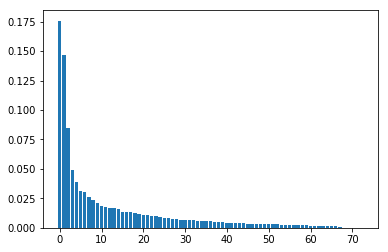

In [53]:
# Investigate the variance accounted for by each principal component.
ratio =  np.arange(len(pca.explained_variance_ratio_))
cum_var = pca.explained_variance_ratio_
plt.bar(ratio, cum_var)

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(20)
pca_fit_new = pca.fit(under_20_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I used the PCA class of sklearn to apply principle componant analysis. Initially, I did this without setting any parameters so that all componants were computed. Based on the outputted chart, I felt that reducing the number of componants to 20 better suits the dataset. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.   
def weights_func(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(under_20_scaled.columns))
    weights = df.iloc[i].sort_values()
    return weights

In [56]:
weights_func(pca_fit_new, 0)

59   -0.204431
2    -0.202943
55   -0.202470
49   -0.193641
44   -0.192147
39   -0.152078
65   -0.150688
52   -0.146481
11   -0.130994
12   -0.116745
4    -0.113864
50   -0.111977
0    -0.111802
53   -0.107351
9    -0.090026
32   -0.079576
42   -0.075797
21   -0.071853
58   -0.067912
20   -0.067631
36   -0.059028
40   -0.045069
56   -0.039170
19   -0.036431
14   -0.022520
33   -0.003621
29   -0.001894
24    0.003760
1     0.006235
45    0.010882
        ...   
5     0.070435
18    0.072214
16    0.072333
6     0.077392
28    0.082015
8     0.085949
23    0.087074
69    0.105228
70    0.105228
13    0.105228
17    0.105257
27    0.107115
68    0.121062
46    0.121621
37    0.122754
66    0.128973
60    0.138562
47    0.140704
3     0.142322
7     0.142954
48    0.154217
51    0.174657
67    0.177341
34    0.182615
43    0.192356
71    0.192356
72    0.192356
63    0.194544
62    0.197693
61    0.203670
Name: 0, Length: 73, dtype: float64

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_func(pca_fit_new, 1)

70   -0.246161
69   -0.246161
13   -0.246161
3    -0.222469
6    -0.216892
5    -0.203957
17   -0.203510
8    -0.201125
28   -0.197200
27   -0.196422
31   -0.177887
23   -0.161377
56   -0.158601
22   -0.156318
16   -0.124781
18   -0.123868
59   -0.089152
49   -0.084506
55   -0.076087
44   -0.070786
65   -0.069563
32   -0.068758
52   -0.067735
39   -0.067149
15   -0.057730
10   -0.054123
50   -0.053621
12   -0.052449
42   -0.046204
40   -0.046057
        ...   
25    0.026636
38    0.027501
1     0.037554
46    0.048018
36    0.053575
34    0.059398
26    0.059922
37    0.060217
68    0.061426
60    0.062537
66    0.064912
47    0.068438
48    0.069752
24    0.070326
2     0.071762
63    0.082783
67    0.083250
51    0.083989
72    0.086571
43    0.086571
71    0.086571
62    0.087388
61    0.090032
7     0.107084
35    0.121542
14    0.157224
20    0.157629
21    0.173488
4     0.219847
0     0.224739
Name: 1, Length: 73, dtype: float64

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_func(pca_fit_new, 2)

1    -0.375301
26   -0.350190
25   -0.320371
24   -0.290660
21   -0.219429
23   -0.171301
5    -0.142852
70   -0.065796
69   -0.065796
13   -0.065796
3    -0.059748
7    -0.059174
6    -0.057436
8    -0.052648
31   -0.048803
59   -0.027569
27   -0.025914
65   -0.024680
28   -0.024675
56   -0.024532
52   -0.021209
39   -0.020241
34   -0.020138
10   -0.019930
53   -0.019260
58   -0.015773
50   -0.015636
55   -0.011433
49   -0.010624
44   -0.009477
        ...   
11    0.006895
41    0.012880
37    0.012881
47    0.014370
60    0.015376
68    0.015767
48    0.017931
43    0.019254
71    0.019254
72    0.019254
66    0.019391
51    0.019851
36    0.020268
0     0.020594
67    0.020958
20    0.021683
61    0.024572
62    0.026310
63    0.029690
9     0.032562
4     0.055479
35    0.062946
14    0.073978
18    0.091992
17    0.123677
2     0.137008
15    0.275485
22    0.276092
16    0.282296
19    0.348491
Name: 2, Length: 73, dtype: float64

In [59]:
pca = PCA(20)
pca_fit_new = pca.fit_transform(under_20_scaled)

### Discussion 2.3: Interpret Principal Components

We can interpret features 59 and 2 from the first principal componant as having a positive correlation. These features are PLZ8_ANTG1 (number of 1-2 family houses in the region) and FINANZ_MINIMALIST (financial topology: low financial interest).

Features 61 and 62 from the first principal componant have a negative correlation. These features, PLZ8_ANTG3 and PLZ8_ANTG4,adress the number of 6-10-family houses and 10+ family houses in the region .

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
from sklearn.cluster import KMeans 

scores = []
clusters = list(range(1,10))

In [61]:
# Over a number of different cluster counts...  
    # run k-means clustering on the data and...
for item in clusters:
    kmeans = KMeans(n_clusters=item)
    cluster_kmeans = kmeans.fit(pca_fit_new)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(pca_fit_new))
    scores.append(score)

Text(0,0.5,'Distance')

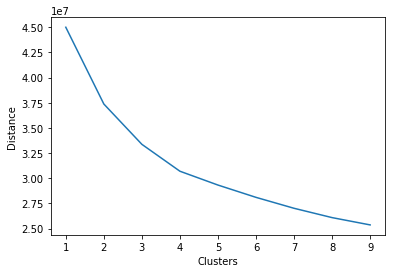

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores)
plt.xlabel("Clusters")
plt.ylabel("Distance")

In [63]:
# refit
kmeans = KMeans(n_clusters=10)
kmeans_overall = kmeans.fit(pca_fit_new)
pred_overall = kmeans_overall.predict(pca_fit_new)

### Discussion 3.1: Apply Clustering to General Population

For this activity, I used KMeans to cluster PCA data. I chose to segment the population into 10 clusters. I felt that this was a good amount in order to capture the neccesary amount of data while having enough clusters with which to work. I plotted the data in the above chart in order to show within-cluster  distance across the number of clusters. Finally, I refit KMeans.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cust_cleaned = clean_data(customers)

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_SPARER                 0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
GREEN_AVANTGARDE              0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB        240
HH_EINKOMMEN_SCORE         2968
CJT_GESAMTTYP              3213
ONLINE_AFFINITAET          3213
GFK_URLAUBERTYP            3213
RETOURTYP_BK_S             3213
                          ...  
CAMEO_IN

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [66]:
#checking number of NaN's present
cust_cleaned.isnull().sum().sum()

241128

In [67]:
#Filling NaN's
imputery = Imputer(strategy='most_frequent')
cust_cleaned_imputed = pd.DataFrame(imputery.fit_transform(cust_cleaned))

In [68]:
#checking number of NaN's again
cust_cleaned_imputed.isnull().sum().sum()

0

In [69]:
#applying feature scaling
scalar = StandardScaler()
cust_cleaned_scaled = scalar.fit_transform(cust_cleaned_imputed)
cust_cleaned_scaled = pd.DataFrame(cust_cleaned_imputed, columns=cust_cleaned_imputed.columns)

In [70]:
# Apply PCA to the data.
pca = PCA()
pca_cust = pca.fit_transform(cust_cleaned_scaled)

In [71]:
#KMeans prediction
kmeans_customers = KMeans(n_clusters=10).fit_predict(pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# creating comparison function to print vizualizations
def comparison(overall, subset):
    fig = plt.figure()
    
    fig.set_figwidth(12)
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text("Overall Clusters")
    sns.countplot(overall)
                            
    ax2 = fig.add_subplot(122)
    ax2.title.set_text("Customer Clusters")
    sns.countplot(subset)

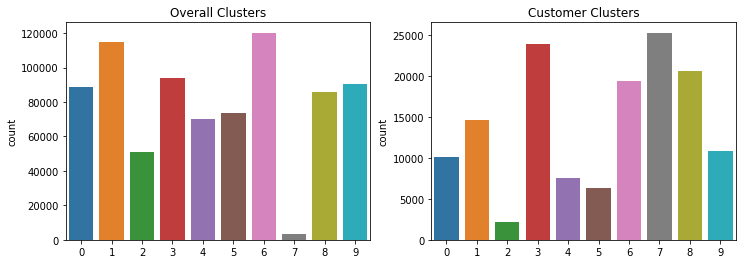

In [73]:
comparison(pred_overall, kmeans_customers)

In [74]:
pca = PCA()
pca_cust_new = pca.fit(cust_cleaned_scaled)

In [75]:
#using a similar function to section 2.3
def weights_func_2(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(cust_cleaned_scaled.columns))
    weights = df.iloc[i].sort_values()
    return weights

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
weights_func_2(pca_cust_new, 0)

43   -0.005429
72   -0.005429
71   -0.005429
37   -0.001856
67   -0.001301
68   -0.001042
51   -0.000974
63   -0.000794
66   -0.000648
34   -0.000640
7    -0.000456
48   -0.000358
26   -0.000266
25   -0.000232
46   -0.000204
61   -0.000193
21   -0.000193
35   -0.000192
62   -0.000192
24   -0.000184
14   -0.000158
57   -0.000157
47   -0.000119
41   -0.000101
60   -0.000101
54   -0.000089
20   -0.000053
45   -0.000051
1    -0.000048
3    -0.000043
        ...   
18    0.000063
4     0.000063
70    0.000077
69    0.000077
13    0.000077
28    0.000094
6     0.000113
17    0.000114
22    0.000114
53    0.000151
32    0.000152
39    0.000155
56    0.000171
19    0.000172
59    0.000282
2     0.000316
8     0.000326
49    0.000331
12    0.000453
31    0.000459
50    0.000484
44    0.000499
55    0.000535
40    0.000572
42    0.000746
52    0.000872
11    0.001650
64    0.001967
65    0.002054
58    0.999944
Name: 0, Length: 73, dtype: float64

In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

weights_func_2(pca_cust_new, 6)

67   -0.460159
51   -0.331699
68   -0.170126
66   -0.134577
61   -0.114130
63   -0.106382
18   -0.097705
60   -0.084802
14   -0.069205
13   -0.067751
70   -0.067751
69   -0.067751
62   -0.067724
64   -0.065929
7    -0.060249
48   -0.059319
15   -0.055570
22   -0.049706
9    -0.046435
11   -0.045932
35   -0.045898
25   -0.042355
45   -0.040615
46   -0.039795
16   -0.038980
17   -0.031472
28   -0.028819
19   -0.027737
20   -0.019891
6    -0.017930
        ...   
10    0.002912
38    0.004282
1     0.009053
4     0.012948
24    0.013845
26    0.015936
0     0.020543
72    0.020613
71    0.020613
43    0.020613
34    0.023709
65    0.034745
53    0.035540
32    0.036581
2     0.045090
37    0.045270
5     0.062467
21    0.074733
44    0.076961
49    0.077804
54    0.078399
59    0.084608
55    0.099645
57    0.101941
39    0.154493
31    0.155952
40    0.158952
52    0.350345
42    0.362547
50    0.373044
Name: 6, Length: 73, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data
For this section, I reused part of my code from section 2.3 in order to compare the customer clusters to overall clusters. Cluster 0 is overrepresented within the customer subset. Some key features of this subset are 72 (LIFE_STAGE_CAMEO) and 71 (WEALTH_CAMEO). These columns deal with a person's stage life and their cumulative wealth level. Since these factors are positively correlated, one can infer that the later in life a person is and the higher their level of wealth, the more popular the mail-order company will be with them. This makes sense, since common sense is that folks with more disposable money are more likely to mail-order products than those who are struggling. 

Cluster 6 is underrepresented within the customer subset. Some key features of this subset are 67 (RELAT_AB) and 68 (ORTSGR_KLS9). These features are regarding unemployment rates and size of the community. These features are negatively correlated, so one can infer that the smaller the community and the lower the rates of unemployment, the more popular the mail-order company is with people. This makes sense, since lower unemployment rates means that folks have more disposable income with which to order items, as well as the fact that folks in smaller communities seem more likely to order via mail since they do not have access to major box stores to the same degree that those from larger cities would.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.